In [6]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CP2LFI.simulations import predict_naive_quantile
from CP2LFI.posterior_models import normflow_posterior
from clover import LocartSplit

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg
# mg1 data (queue theory)
from hypothesis.benchmark import mg1
# multivariate normal (toy example)
from hypothesis.benchmark import tractable

## Proof of concept of our methods:

Comparing estimated cutoffs to real cutoffs in weinberg dataset

In [7]:
# posterior model
def fit_post_model(
        simulator, 
        prior,
        log_transf = False, 
        B_model = 20000, 
        n = 1, 
        seed = 45, 
        split_seed = 0,
        n_flows = 8, 
        hidden_units = 128,
        hidden_layers = 2,
        enable_cuda = True,
        patience = 50,
        n_epochs = 2000,
        batch_size = 250,
        type_flow = "Quadratic Spline",
        plot_history = True):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # simulating thetas
        thetas = prior.sample((B_model, ))
        repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

        # simulating X's
        X_sample = simulator(repeated_thetas)
        # applying log if needed
        if log_transf:
                X_sample = torch.log(X_sample)
        X_dim = X_sample.shape[1]
        X_net = X_sample.reshape(B_model, n * X_dim)

        if thetas.ndim == 1:
                thetas = thetas.reshape(-1, 1)
        nflow_post = normflow_posterior(
        latent_size = thetas.shape[1],
        sample_size = X_net.shape[1], 
        n_flows = n_flows, 
        hidden_units = hidden_units, 
        hidden_layers = hidden_layers,
        enable_cuda = enable_cuda,
        )

        nflow_post.fit(
                X_net.numpy(), 
                thetas.numpy(), 
                patience = patience, 
                n_epochs = n_epochs, 
                batch_size = batch_size, 
                split_seed = split_seed,
                type = type_flow,
                )
        if plot_history:
                nflow_post.plot_history()
        
        return nflow_post

# defining monte carlo function
def naive(kind, simulator, score, alpha, B=1000, N=100, naive_n=500, disable_tqdm = True, log_transf = False):
    n_grid = int(B / naive_n)
    quantiles = {}

    if kind == "weinberg":
        thetas = np.linspace(0.5001, 1.4999, n_grid)
        for theta in tqdm(thetas, desc = "fitting monte carlo cutoffs"):
            theta_fixed = torch.tensor([theta])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)

            if log_transf:
                X_samples = torch.log(X_samples)

            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(thetas = repeated_thetas.numpy()[0:naive_n, :], X = X_samples.numpy(), disable_tqdm = disable_tqdm)

            quantiles[theta] = np.quantile(lambdas, q = 1 - alpha)

    elif kind == "tractable":
        # given the complexity, reducing to only 10 grid if B > 5000
        par_grid = np.linspace(-2.9999, 2.9999, int(np.ceil(n_grid**(1/5)))) 

        for theta_1, theta_2, theta_3, theta_4, theta_5 in tqdm(itertools.product(par_grid, par_grid, par_grid, par_grid, par_grid), 
                                                                desc ="fitting monte carlo cutoffs"):
            theta_fixed = torch.tensor([theta_1, theta_2, theta_3, theta_4, theta_5])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)

            if log_transf:
                X_samples = torch.log(X_samples)

            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(thetas = repeated_thetas.numpy()[0:naive_n, :], X = X_samples.numpy(), disable_tqdm = disable_tqdm)

            quantiles[(theta_1, theta_2, theta_3, theta_4, theta_5)] = np.quantile(lambdas, q = 1 - alpha)

    elif kind == "mg1":
        pars_1 = np.linspace(0.0001, 9.9999, int(np.ceil(n_grid**(1/3))))
        pars_2 = np.linspace(0.0001, 1/3 - 0.0001, int(np.ceil((n_grid)**(1/3))))

        for par1, par2, par3 in tqdm(itertools.product(pars_1, pars_1, pars_2), desc = "fitting monte carlo cutoffs"):
            theta_fixed = torch.tensor([par1, par2, par3])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)
            
            if log_transf:
                X_samples = torch.log(X_samples)
                
            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(
                thetas = repeated_thetas.numpy()[0:naive_n, :],
                X = X_samples.numpy(), 
                one_sample = False,
                disable_tqdm = disable_tqdm)

            quantiles[(par1, par2, par3)] = np.quantile(lambdas, q = 1 - alpha)
    return quantiles

# prediction function for naive
def predict_naive_quantile(kind, theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        if kind == "weinberg":
            idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
            quantiles_list.append(quantiles_dict[idx])
        else:
            distances = np.linalg.norm(thetas_values - theta, axis=1)
            idx = thetas_values[np.argmin(distances)]
            quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

# function to compute quantiles
def obtain_quantiles(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 50,
    B_valid=1000,
    N_lambda = 150,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
    log_transf = False,
):
    # fitting and predicting naive (monte-carlo
    print("Running naive method")
    naive_quantiles = naive(
        kind = kind, 
        simulator = simulator, 
        score = score, 
        alpha = alpha, 
        B=B, 
        N=N, 
        naive_n= naive_n, 
        log_transf = log_transf
        )
    naive_list = predict_naive_quantile(kind, theta_grid_eval, naive_quantiles)

    # simulating to fit models
    thetas_sim = prior.sample((B,))
    if thetas_sim.ndim == 1:
        model_thetas = thetas_sim.reshape(-1, 1)
    else:
        model_thetas = thetas_sim

    repeated_thetas = thetas_sim.repeat_interleave(repeats = N, dim = 0)
    X_net = simulator(repeated_thetas)
    if log_transf:
        X_net = torch.log(X_net)
    X_dim = X_net.shape[1]
    X_net = X_net.reshape(B, N * X_dim)

    model_lambdas = score.compute(model_thetas.numpy(), X_net.numpy(), disable_tqdm = disable_tqdm)
    print(model_lambdas)

    print("Running all the other methods")
    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas.numpy(), model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas.numpy(), 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators= n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas.numpy(), model_lambdas)

    print("Obtaining tuning sample")
    # tuned loforest samples
    theta_tune = prior.sample((B_valid, ))

    # finding tuned K
    lambda_tune = np.zeros((theta_tune.shape[0], N_lambda))
    if theta_tune.ndim == 1:
        K_valid_thetas = theta_tune.reshape(-1, 1)
    else:
        K_valid_thetas = theta_tune

    i = 0
    for theta in tqdm(theta_tune, desc = "Simulating all tuning sample"):
        if theta_tune.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = N_lambda*N, dim = 0)
        else:
            theta_repeated = theta.reshape(1, -1).repeat_interleave(repeats = N_lambda*N, dim = 0)
            
        X_net = simulator(theta_repeated)
        if log_transf:
            X_net = torch.log(X_net)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(N_lambda, N * X_dim)
        lambda_tune[i, :] = score.compute(thetas = theta_repeated.numpy()[0:N_lambda, :], X = X_net.numpy(), disable_tqdm = disable_tqdm)
        i += 1

    print("Fitting tuned loforest")
    K_loforest = tune_loforest_LFI(
        loforest_object, theta_data = K_valid_thetas.numpy(), lambda_data = lambda_tune, K_grid=K_grid
    )

    # locart quantiles
    if theta_grid_eval.ndim == 1:
        model_eval = theta_grid_eval.reshape(-1, 1)
    else:
        model_eval = theta_grid_eval

    idxs = locart_object.cart.apply(model_eval)
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(model_eval)

    # tuned loforest
    loforest_tuned_cutoffs = loforest_object.compute_cutoffs(
        model_eval, K=K_loforest
    )

    # boosting
    boosting_quantiles = model.predict(model_eval)


    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest_fixed": loforest_cutoffs,
        "loforest_tuned": loforest_tuned_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict

In [8]:
def compare_to_real(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N = 1,
    B = 10000,
    alpha=0.05,
    min_samples_leaf = 300,
    n_estimators = 200,
    K = 50,
    B_valid= 500,
    N_lambda = 250,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
    seed = 45,
    n_lambda = 1000,
    log_transf = False,
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    quantiles_dict = obtain_quantiles(
    kind = kind,
    score = score, 
    theta_grid_eval = theta_grid_eval, 
    simulator = simulator,
    prior = prior, 
    N = N, 
    B = B, 
    alpha = alpha, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators, 
    K = K,
    disable_tqdm = disable_tqdm,
    B_valid = B_valid,
    N_lambda= N_lambda,
    K_grid = K_grid,
    naive_n = naive_n,
    log_transf = log_transf,
)
    mae_list, se_list, methods_list, N_list, B_list = [], [], [], [], []

    locart_cover, loforest_cover = np.zeros(theta_grid_eval.shape[0]), np.zeros(theta_grid_eval.shape[0])
    loforest_tuned_cover, boosting_cover = np.zeros(theta_grid_eval.shape[0]), np.zeros(theta_grid_eval.shape[0])
    naive_cover, real_cutoff = np.zeros(theta_grid_eval.shape[0]), np.zeros(theta_grid_eval.shape[0])
    err_data = np.zeros((theta_grid_eval.shape[0], 5))

    l = 0
    for theta in tqdm(theta_grid_eval, desc = "Computing real cutoffs for the grid"):
        if theta_grid_eval.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        else:
            theta_repeated = torch.tensor([theta]).repeat_interleave(repeats = n_lambda*N, dim = 0)
        # simulating lambdas for testing
        X_net = simulator(theta_repeated)
        if log_transf:
            X_net = torch.log(X_net)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, N * X_dim)

        stat = score.compute(theta_repeated.numpy()[0:n_lambda, :], X_net.numpy(), disable_tqdm = True)

        # real cutoff
        real_cutoff[l] = np.quantile(stat, 1 - alpha)
                
        # comparing the real cutoff to the estimated
        naive_real = np.abs(real_cutoff[l] - quantiles_dict["naive"][l])
        locart_real = np.abs(real_cutoff[l] - quantiles_dict["locart"][l])
        loforest_real = np.abs(real_cutoff[l] - quantiles_dict["loforest_fixed"][l])
        loforest_tuned_real = np.abs(real_cutoff[l] - quantiles_dict["loforest_tuned"][l])
        boosting_real = np.abs(real_cutoff[l] - quantiles_dict["boosting"][l])

        # comparing coverage of methods
        locart_cover[l] = np.mean(stat <= quantiles_dict["locart"][l])
        loforest_cover[l] = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
        loforest_tuned_cover[l] = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
        boosting_cover[l] = np.mean(stat <= quantiles_dict["boosting"][l])
        naive_cover[l] = np.mean(stat <= quantiles_dict["naive"][l])
        
        # saving in numpy array
        err_data[l, :] = np.array([locart_real, loforest_real, loforest_tuned_real, boosting_real, naive_real])
        l += 1

    mae_list.extend(np.mean(err_data, axis=0).tolist())
    se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta_grid_eval.shape[0])).tolist())
    methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
    N_list.extend([N] * 5)
    B_list.extend([B] * 5)

    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )

    cover_data = pd.DataFrame(
        {
        "TRUST" : locart_cover,
        "TRUST++": loforest_cover,
        "TRUST++ tuned": loforest_tuned_cover,
        "Boosting": boosting_cover,
        "Monte Carlo": naive_cover,
        }
    )

    # graphical comparisson
    # Assuming theta_grid_eval is accessible and its length matches the data
    plt.figure(figsize=(10, 6))

    # Plot real cutoff
    plt.plot(theta_grid_eval, real_cutoff, label='Real Cutoff', color='black', linestyle='--')

    # Plot estimated cutoffs for each method with specified colors
    plt.plot(theta_grid_eval, quantiles_dict["locart"], label='TRUST', marker='o', color='blue', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["loforest_fixed"], label='TRUST++', marker='x', color='green', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["loforest_tuned"], label='TRUST++ Tuned', marker='^', color='red', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["boosting"], label='Boosting', marker='s', color='purple', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["naive"], label='Monte-Carlo', marker='v', color='orange', markersize = 3)

    plt.title('Comparison of Real Cutoff vs Estimated Cutoffs')
    plt.xlabel('Theta Grid')
    plt.ylabel('Cutoff Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # only comparing to trust++ tuned and trust
    plt.figure(figsize=(10, 6))

    # Plot real cutoff
    plt.plot(theta_grid_eval, real_cutoff, label='Real Cutoff', color='black', linestyle='--')

    # Plot estimated cutoffs for each method with specified colors
    plt.plot(theta_grid_eval, quantiles_dict["locart"], label='TRUST', marker='o', color='blue', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["loforest_tuned"], label='TRUST++ Tuned', marker='^', color='red', markersize = 3)
    plt.plot(theta_grid_eval, quantiles_dict["naive"], label='Monte-Carlo', marker='v', color='orange', markersize = 3)


    plt.title('Comparison of Real Cutoff vs Our estimated Cutoffs')
    plt.xlabel('Theta Grid')
    plt.ylabel('Cutoff Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plotting coverage
    plt.figure(figsize=(10, 6))

    # Plot nominal level coverage
    plt.axhline(y = 1 - alpha, color = "black", linestyle = '-')

    # Plot estimated cutoffs for each method with specified colors
    plt.plot(theta_grid_eval, locart_cover, label='TRUST', marker='o', color='blue', markersize = 3)
    plt.plot(theta_grid_eval, loforest_cover, label='TRUST++', marker='x', color='green', markersize = 3)
    plt.plot(theta_grid_eval, loforest_tuned_cover, label='TRUST++ Tuned', marker='^', color='red', markersize = 3)
    plt.plot(theta_grid_eval, boosting_cover, label='Boosting', marker='s', color='purple', markersize = 3)
    plt.plot(theta_grid_eval, naive_cover, label='Monte-Carlo', marker='v', color='orange', markersize = 3)

    plt.title('Comparison of coverage')
    plt.xlabel('Theta Grid')
    plt.ylabel('Coverage')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Setup the figure and subplots grid
    fig, axs = plt.subplots(1, 4, figsize=(16, 8), sharey = True)  # 5 rows, 1 column

    # Nominal level line to be added to all subplots
    nominal_level = 1 - alpha

    methods = [
        ("TRUST", locart_cover, 'blue'),
        ("TRUST++ Tuned", loforest_tuned_cover, 'red'),
        ("Boosting", boosting_cover, 'purple'),
        ("Monte-Carlo", naive_cover, 'orange')
    ]

    for i, (label, cover, color) in enumerate(methods):
        axs[i].plot(theta_grid_eval, cover, label=label, marker='o', color=color, markersize=3)
        axs[i].axhline(y=nominal_level, color="black", linestyle='-')
        axs[i].set_title(f'Coverage for {label}')
        axs[i].set_xlabel('Theta Grid')
        axs[i].set_ylabel('Coverage')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

    return [stats_data, quantiles_dict, real_cutoff, cover_data]

### Comparing the weinberg data for several $n$:

starting by defining a thin grid and the simulator and prior functions:

In [9]:
simulator = weinberg.Simulator(default_beam_energy=40.0)
prior = weinberg.Prior()

# weinberg thin grid
n_out = 1000
thetas_valid = np.linspace(0.5001, 1.4999, n_out)

testing for $n = 1, n = 5, n = 10, n = 25, n = 50, n = 100$ and $B = 10000$:

- $n = 1$

Fitting normalizing flows posterior estimator:   8%|▊         | 167/2000 [00:54<10:02,  3.04it/s]

Early stopping at epoch 167
a


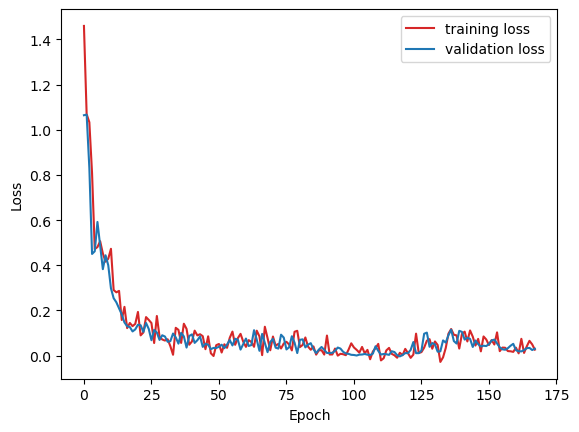

In [10]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 1, seed = 45, split_seed = 0)

In [11]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

BFF statistic:

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [00:01<00:00, 16.42it/s]


[-0.87736696 -1.4223772  -0.9601287  ... -0.9490711  -0.97101194
 -0.9455605 ]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [00:57<00:00, 17.28it/s]


Fitting tuned loforest


Computing real cutoffs for the grid: 100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]


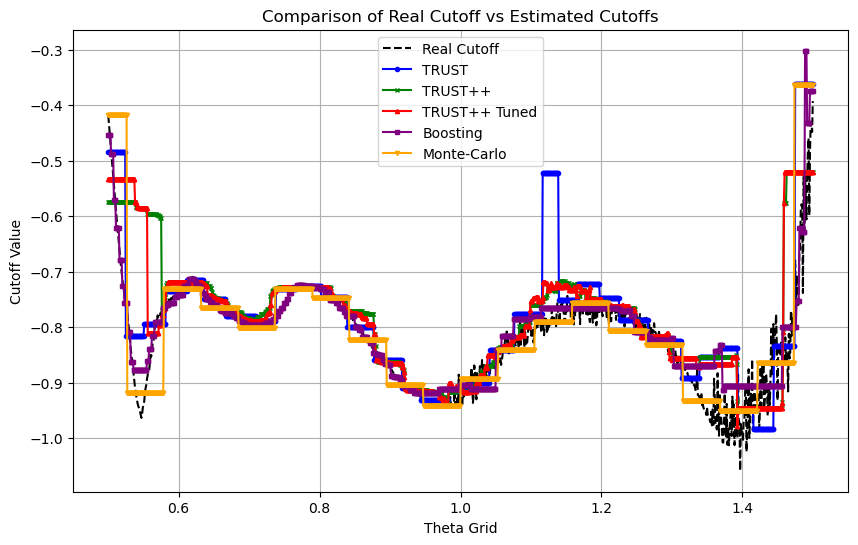

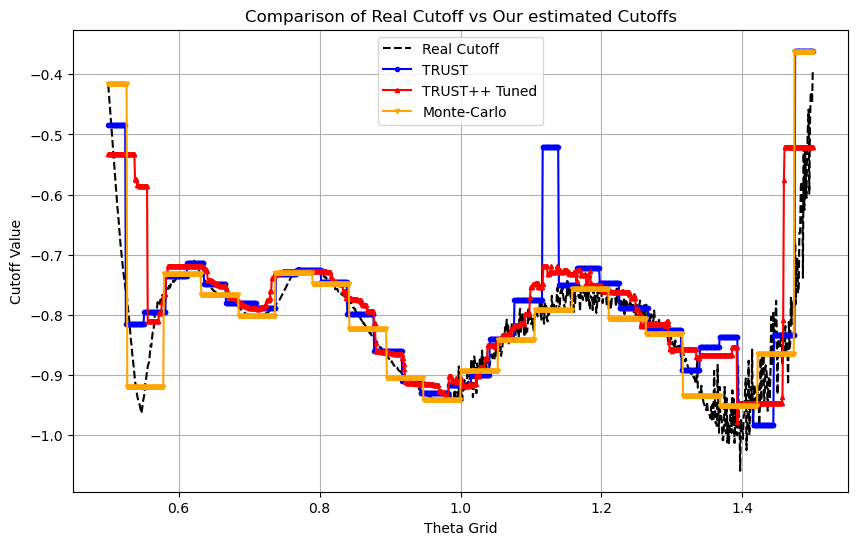

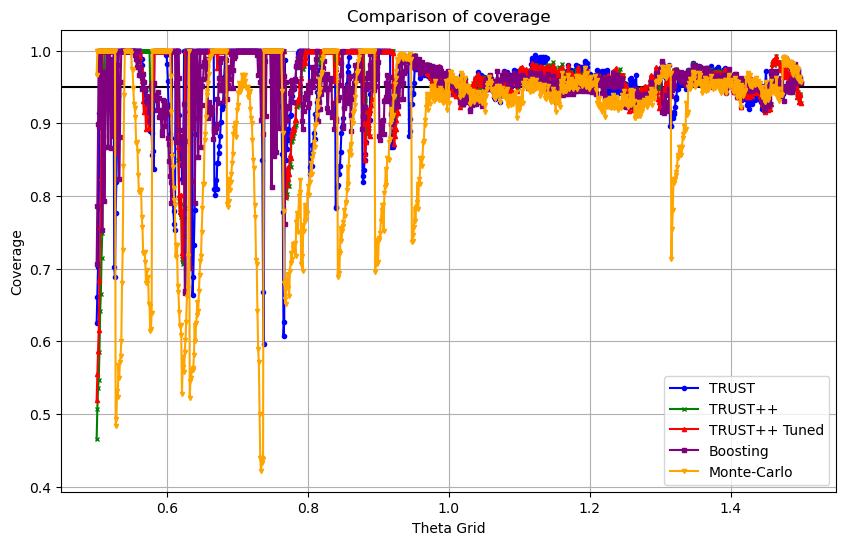

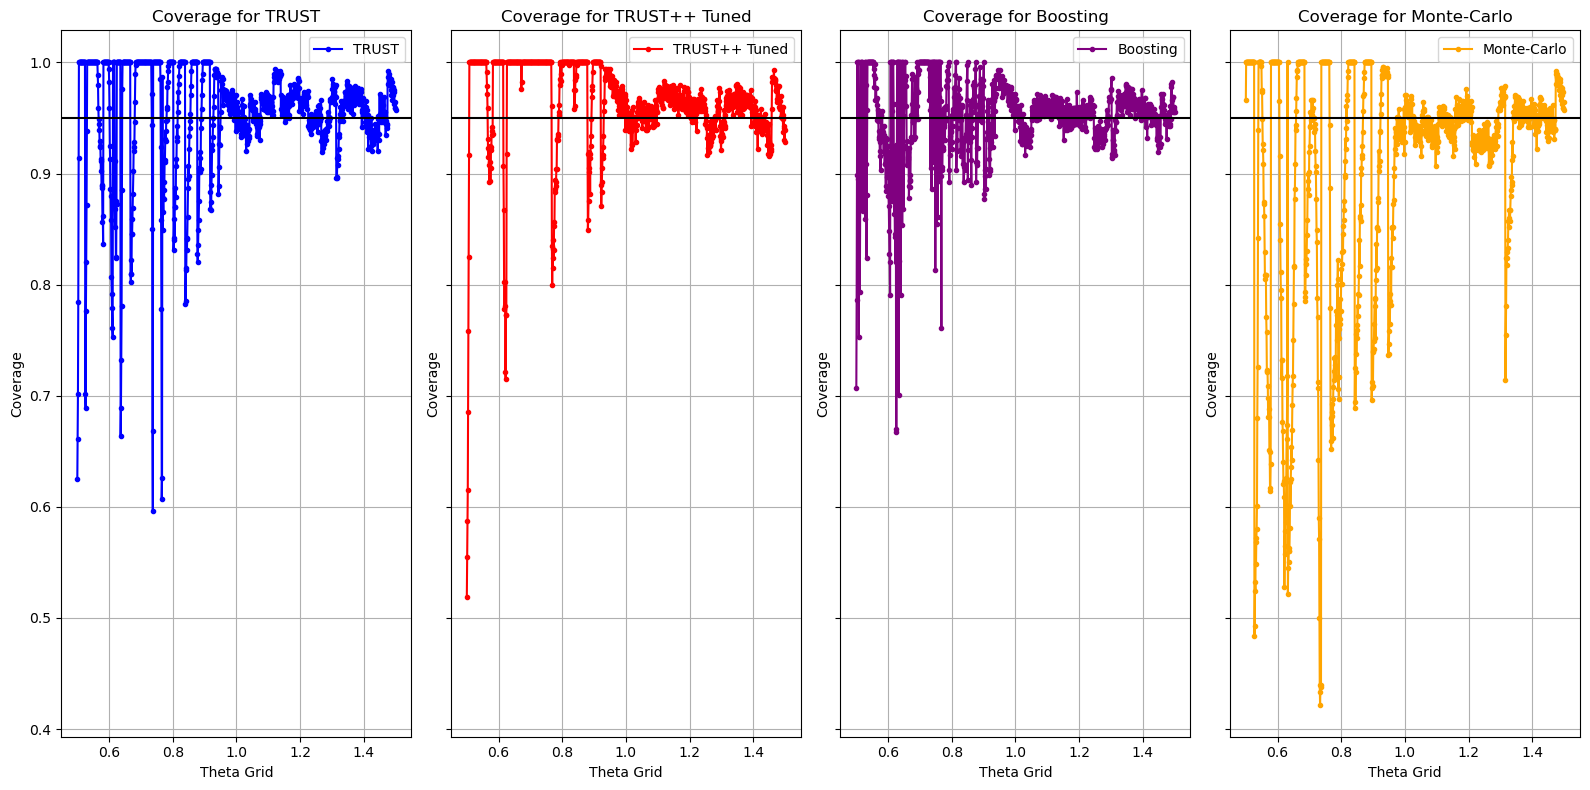

In [12]:
coverage_stats_bff_1 = compare_to_real(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 1, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 250,
    )

In [13]:
coverage_stats_bff_1[0]

,methods,N,B,MAE,se
0,LOCART,1,10000,0.041043,0.002010
1,LOFOREST,1,10000,0.048035,0.002312
2,tuned LOFOREST,1,10000,0.044361,0.002255
3,boosting,1,10000,0.021003,0.000944
4,monte-carlo,1,10000,0.032344,0.001765


computing mean of coverage:

In [14]:
np.mean(np.abs(coverage_stats_bff_1[3] - (1 - 0.05)), axis = 0)

TRUST            0.035346
TRUST++          0.033459
TRUST++ tuned    0.032224
Boosting         0.024282
Monte Carlo      0.066166
dtype: float64

- $n = 5$

Fitting normalizing flows posterior estimator:  13%|█▎        | 267/2000 [01:23<09:02,  3.19it/s]

Early stopping at epoch 267
a


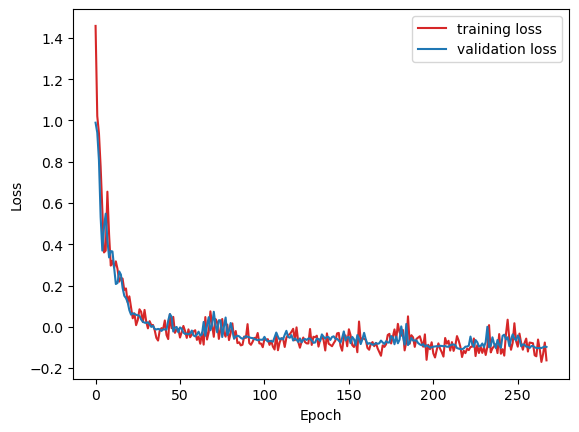

In [15]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 5, seed = 45, split_seed = 0)

In [16]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


[-0.4300208  -2.163361   -1.2092227  ... -1.3569864  -1.1987534
 -0.74563986]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]


Fitting tuned loforest


Computing real cutoffs for the grid: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


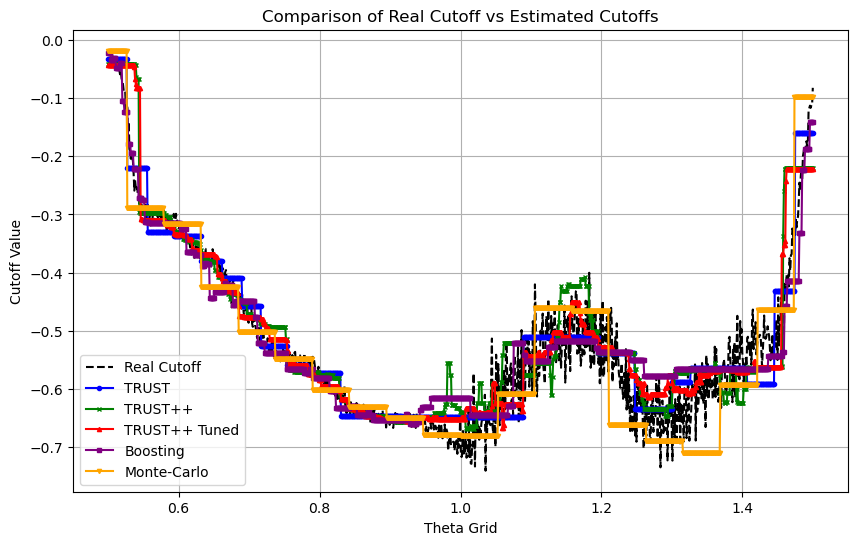

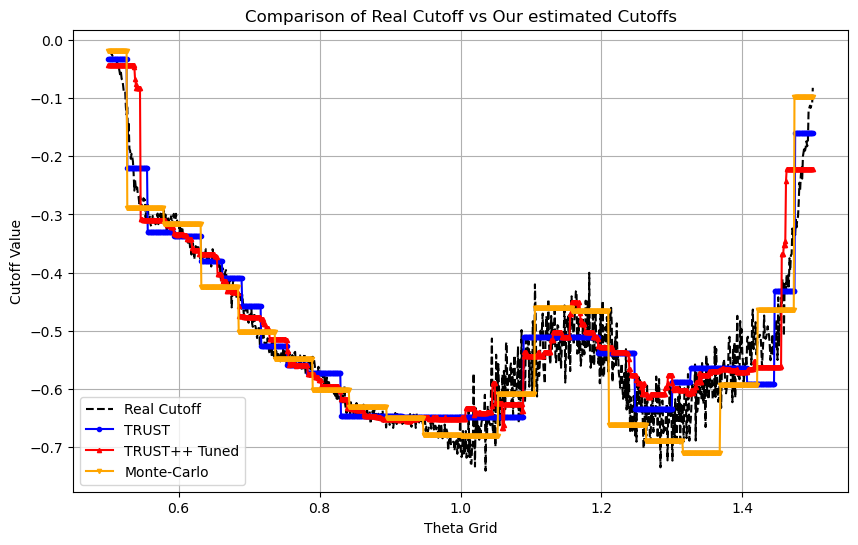

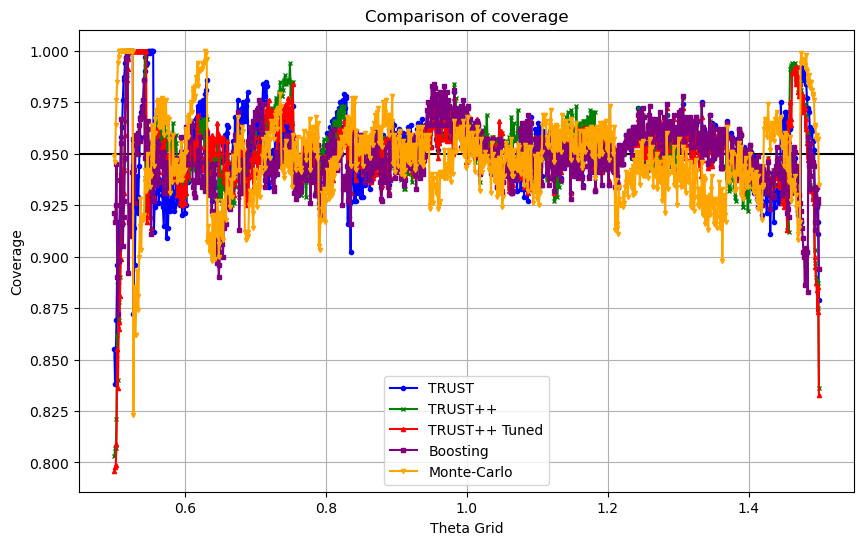

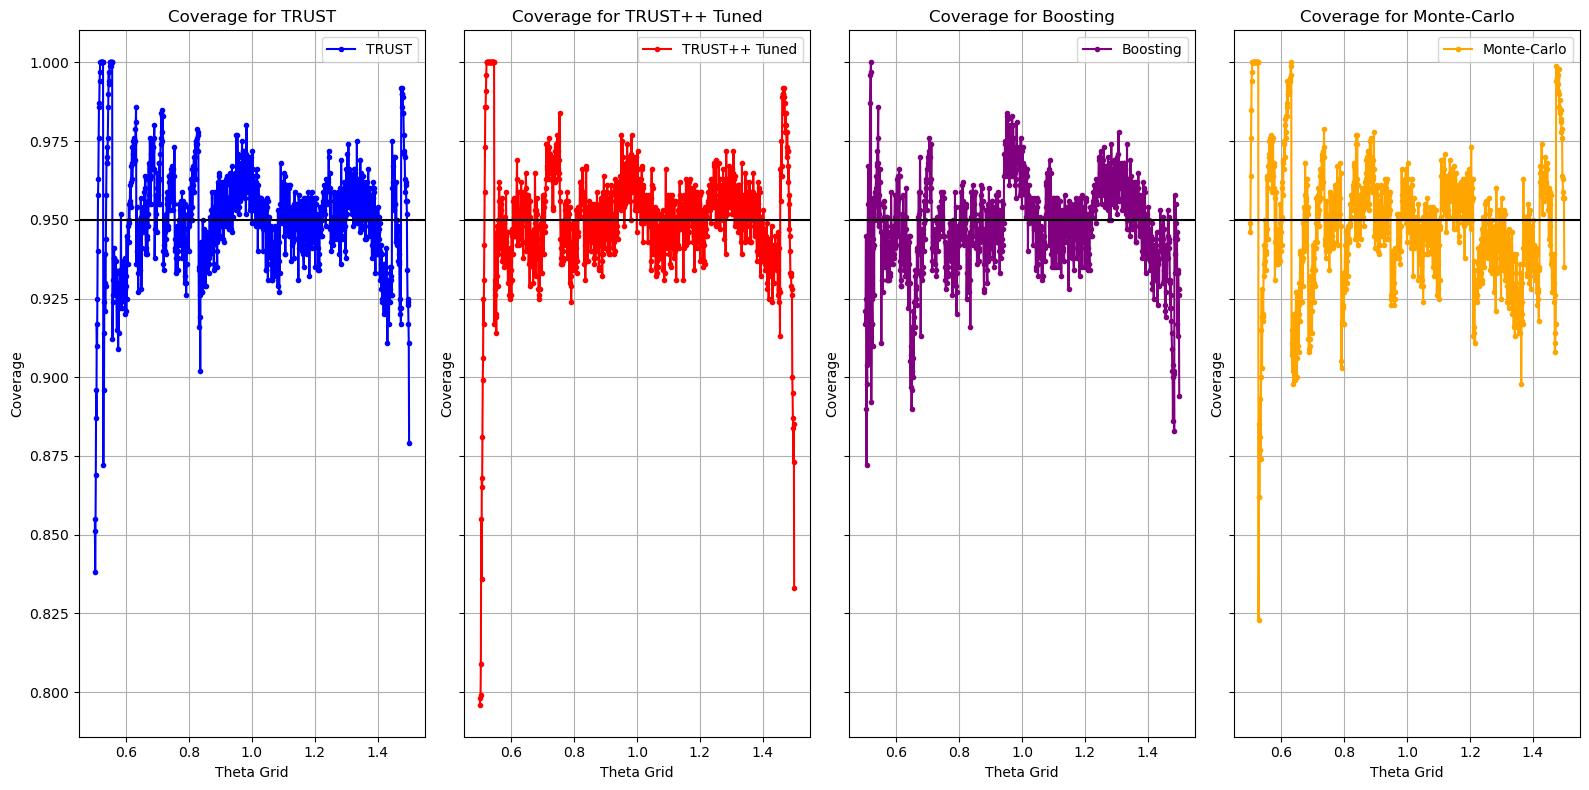

In [17]:
coverage_stats_bff_5 = compare_to_real(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 250,
    )

In [18]:
coverage_stats_bff_5[0]

,methods,N,B,MAE,se
0,LOCART,5,10000,0.032700,0.000940
1,LOFOREST,5,10000,0.039480,0.001298
2,tuned LOFOREST,5,10000,0.033163,0.001141
3,boosting,5,10000,0.033366,0.001002
4,monte-carlo,5,10000,0.041090,0.001274


In [19]:
np.mean(np.abs(coverage_stats_bff_5[3] - (1 - 0.05)), axis = 0)

TRUST            0.012542
TRUST++          0.013271
TRUST++ tuned    0.011815
Boosting         0.011265
Monte Carlo      0.014875
dtype: float64

- $n = 10$

Fitting normalizing flows posterior estimator:  20%|██        | 401/2000 [02:05<08:20,  3.20it/s]

Early stopping at epoch 401
a


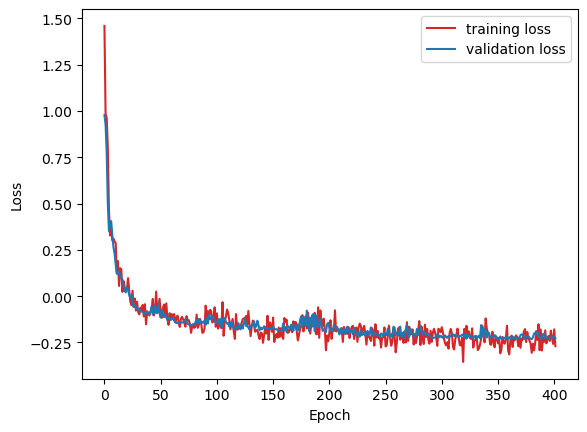

In [20]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 10, seed = 45, split_seed = 0)

In [21]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


[-1.9082049  -1.4374883  -0.28913558 ... -1.4653438  -1.2133449
 -1.0133919 ]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


Fitting tuned loforest


Computing real cutoffs for the grid: 100%|██████████| 1000/1000 [13:07<00:00,  1.27it/s]


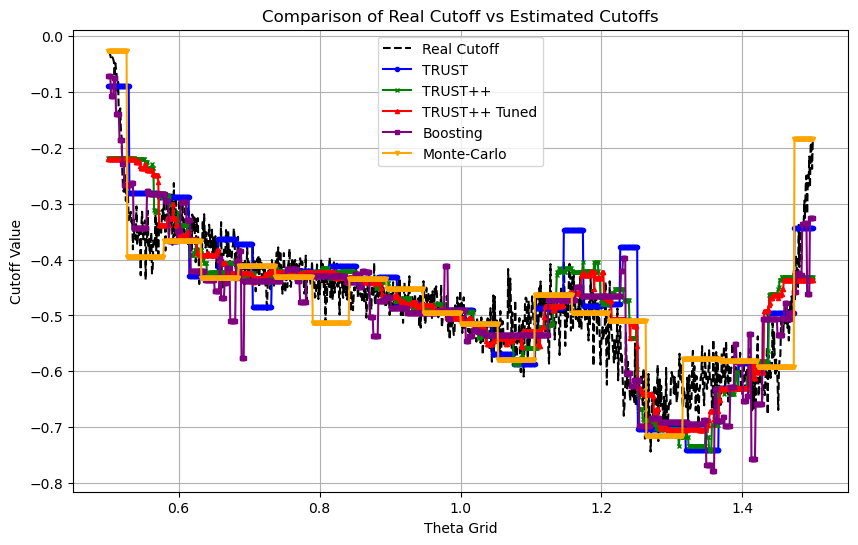

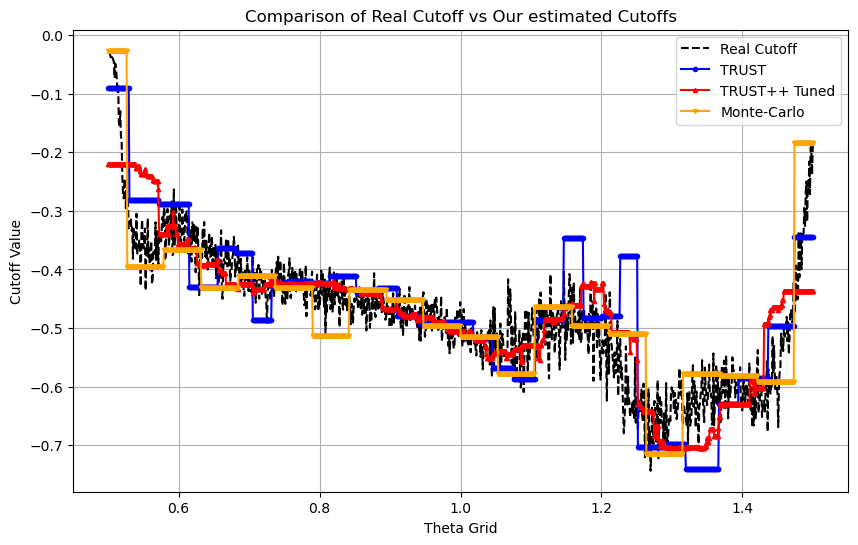

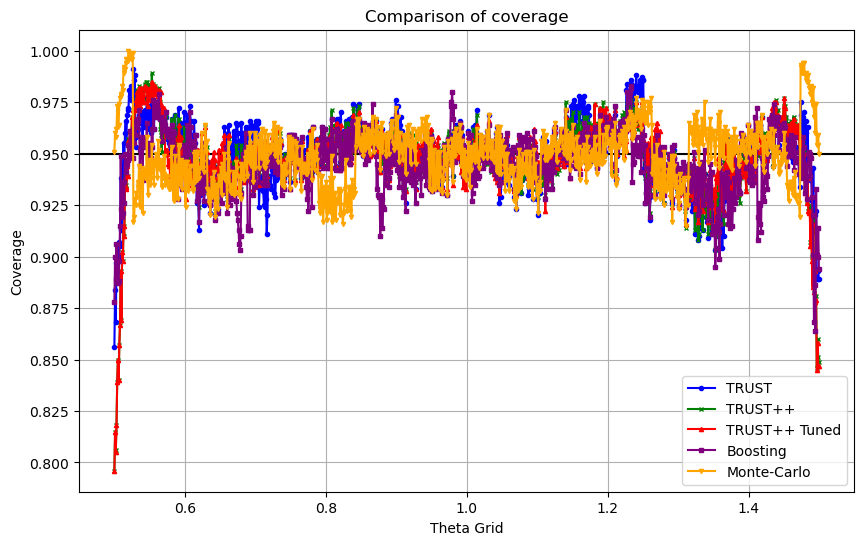

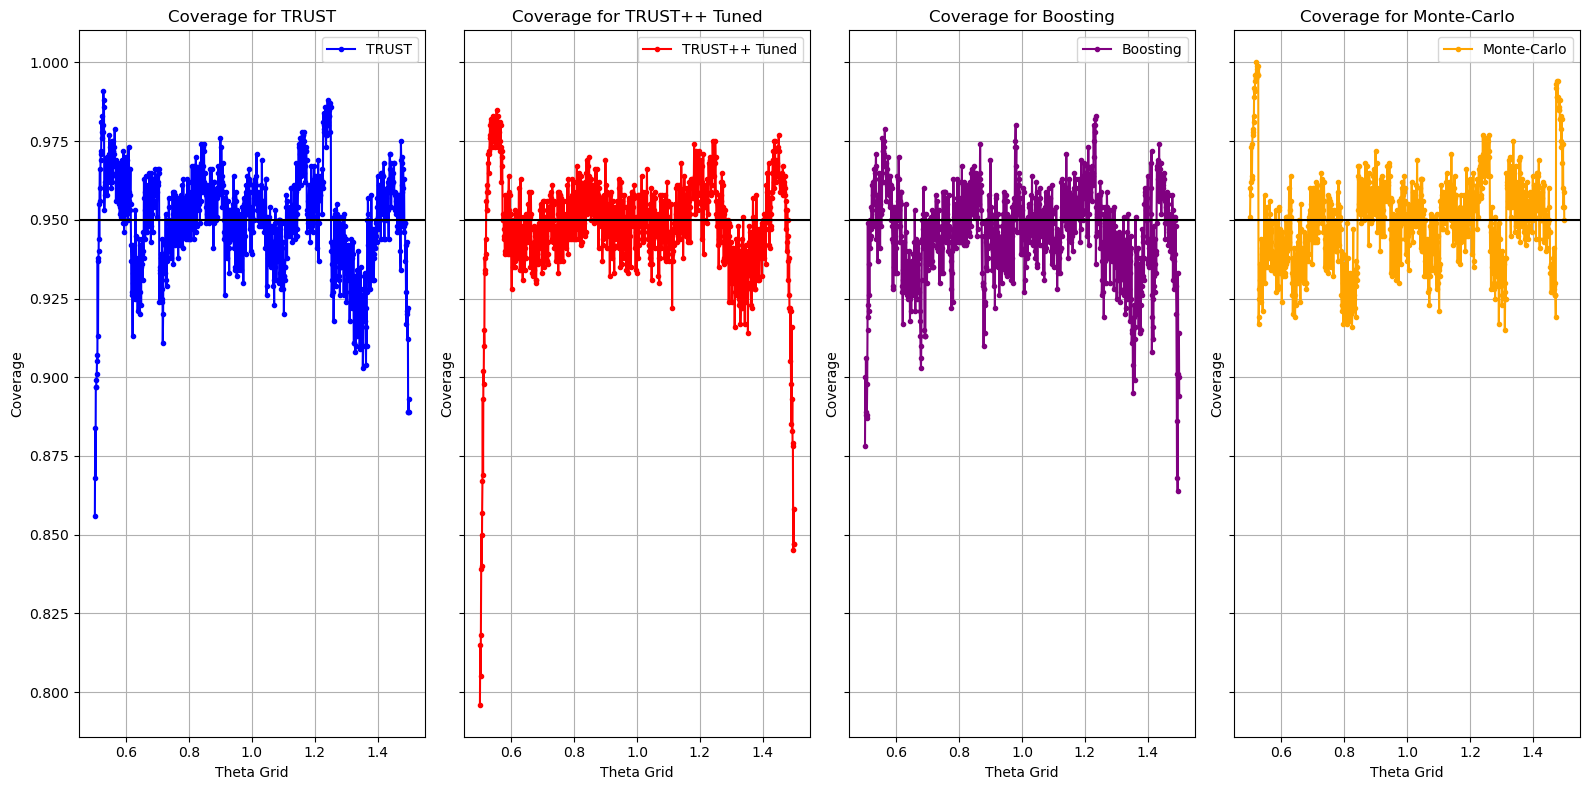

In [22]:
coverage_stats_bff_10 = compare_to_real(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 10, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 250,
    )

In [23]:
coverage_stats_bff_10[0]

,methods,N,B,MAE,se
0,LOCART,10,10000,0.054026,0.001615
1,LOFOREST,10,10000,0.050920,0.001455
2,tuned LOFOREST,10,10000,0.046097,0.001394
3,boosting,10,10000,0.044767,0.001274
4,monte-carlo,10,10000,0.046447,0.001363


In [24]:
np.mean(np.abs(coverage_stats_bff_10[3] - (1 - 0.05)), axis = 0)

TRUST            0.012242
TRUST++          0.012269
TRUST++ tuned    0.011223
Boosting         0.011151
Monte Carlo      0.010898
dtype: float64

- $n = 50$

Fitting normalizing flows posterior estimator:  28%|██▊       | 559/2000 [02:58<07:40,  3.13it/s]

Early stopping at epoch 559
a


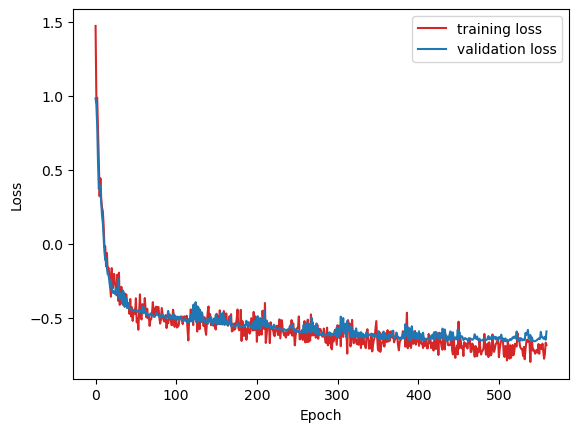

In [25]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 50, seed = 45, split_seed = 0)

In [26]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


[-1.5012774 -3.6825504 -2.1184826 ... -2.731011  -2.181623  -0.5571616]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [33:24<00:00,  2.00s/it]


Fitting tuned loforest


Computing real cutoffs for the grid: 100%|██████████| 1000/1000 [1:02:58<00:00,  3.78s/it]


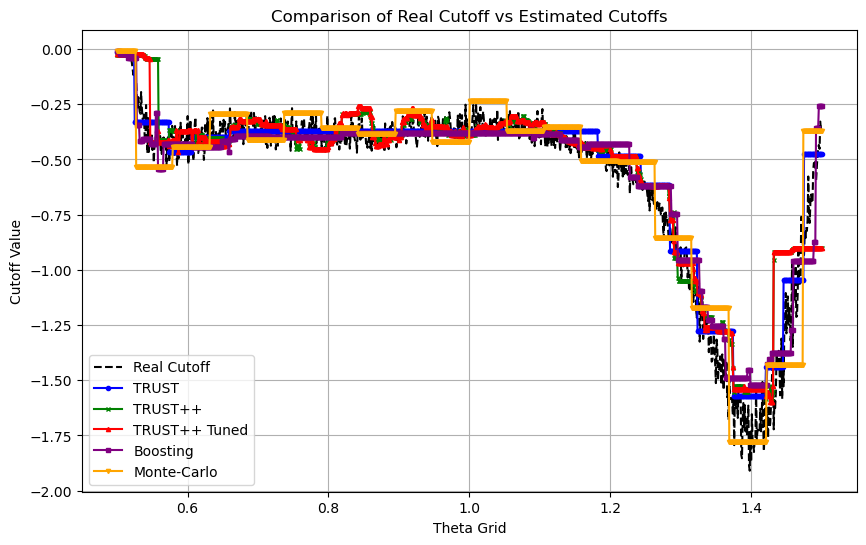

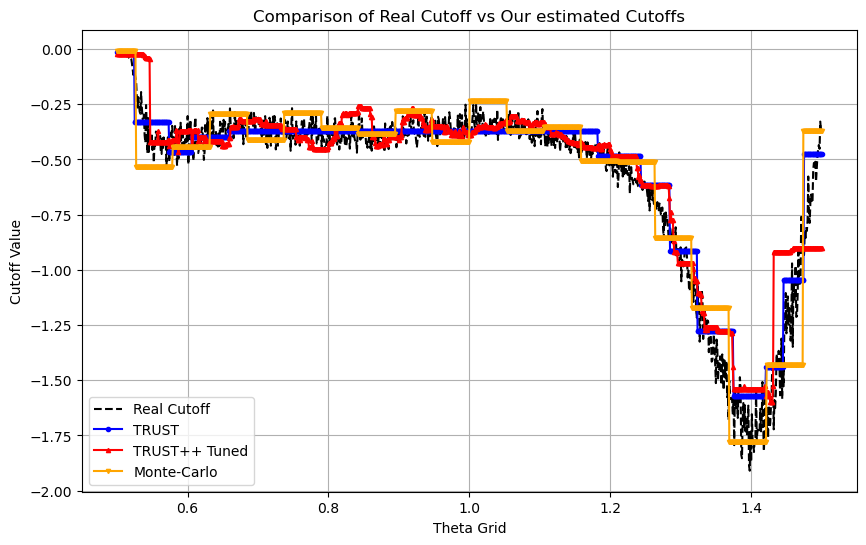

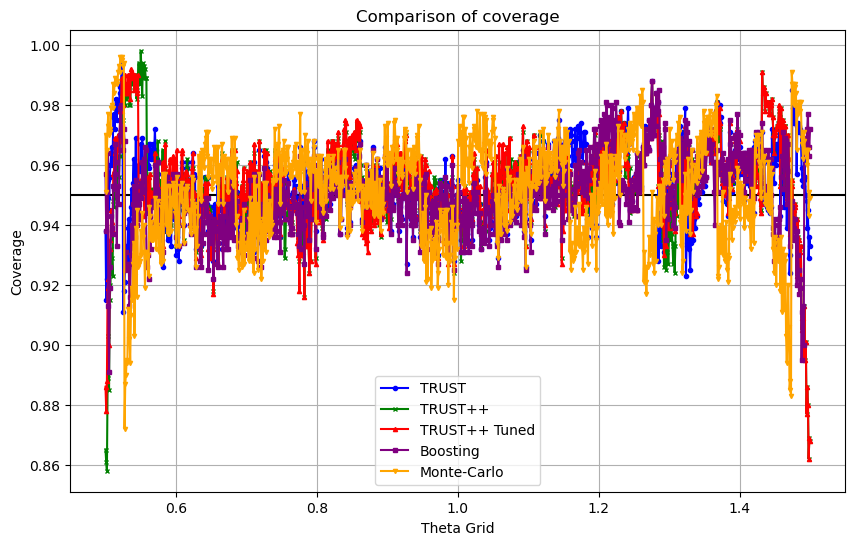

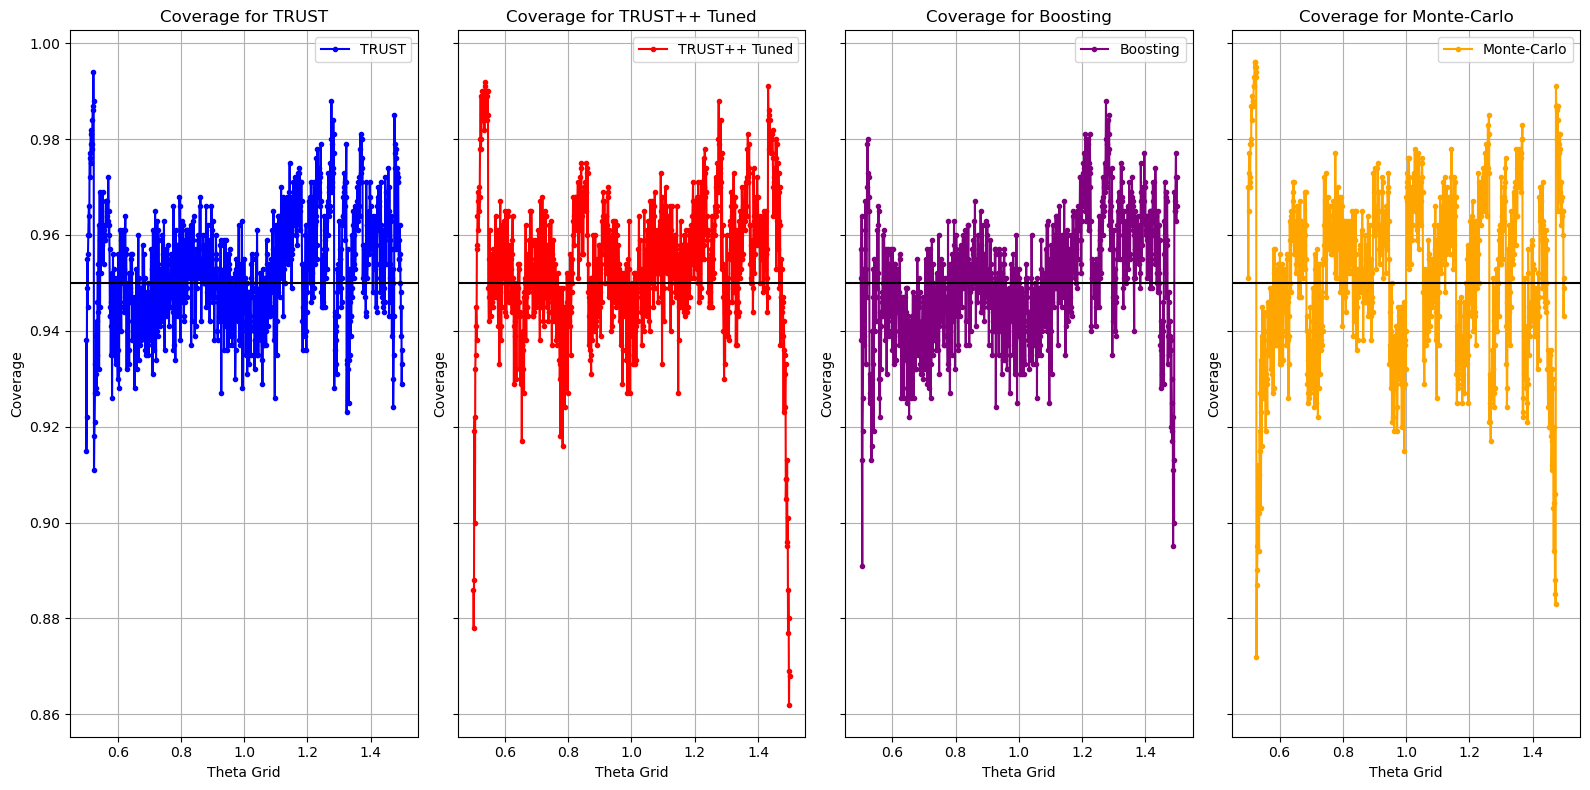

In [27]:
coverage_stats_bff_50 = compare_to_real(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 50, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 250,
    )

In [28]:
coverage_stats_bff_50[0]

,methods,N,B,MAE,se
0,LOCART,50,10000,0.065784,0.002196
1,LOFOREST,50,10000,0.085467,0.003436
2,tuned LOFOREST,50,10000,0.082064,0.003304
3,boosting,50,10000,0.066820,0.002246
4,monte-carlo,50,10000,0.092398,0.002807


In [29]:
np.mean(np.abs(coverage_stats_bff_50[3] - (1 - 0.05)), axis = 0)

TRUST            0.009478
TRUST++          0.011435
TRUST++ tuned    0.011056
Boosting         0.009603
Monte Carlo      0.013724
dtype: float64

In [30]:
np.std(np.abs(coverage_stats_bff_50[3] - (1 - 0.05)), axis = 0)

TRUST            0.007552
TRUST++          0.011809
TRUST++ tuned    0.010885
Boosting         0.007976
Monte Carlo      0.010475
dtype: float64

- $n = 100$

Fitting normalizing flows posterior estimator:  24%|██▍       | 483/2000 [02:26<07:39,  3.30it/s]

Early stopping at epoch 483
a


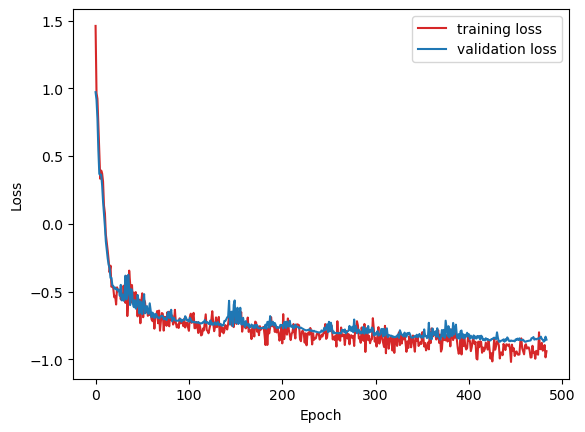

In [31]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 100, seed = 45, split_seed = 0)

In [32]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


[-2.3561049 -4.01195   -3.8759894 ... -3.138541  -2.840476  -3.3066638]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [1:02:35<00:00,  3.76s/it]


Fitting tuned loforest


Computing real cutoffs for the grid: 100%|██████████| 1000/1000 [2:04:26<00:00,  7.47s/it] 


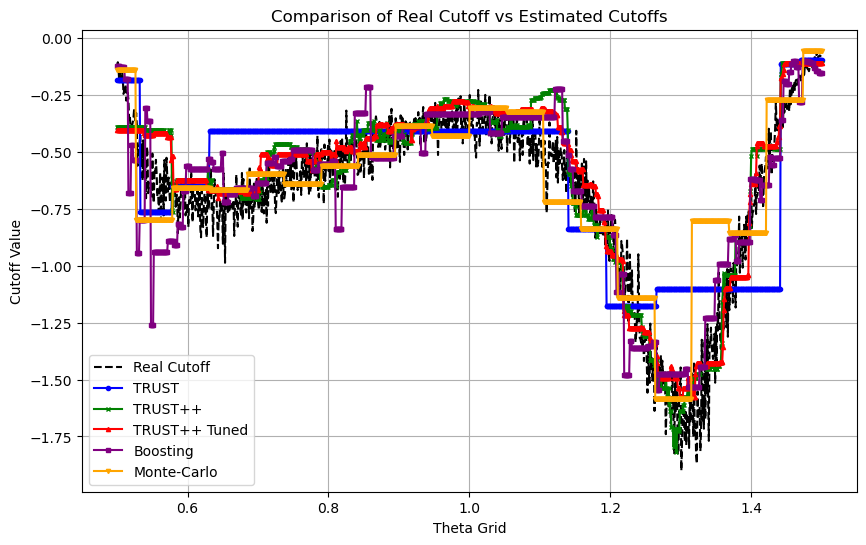

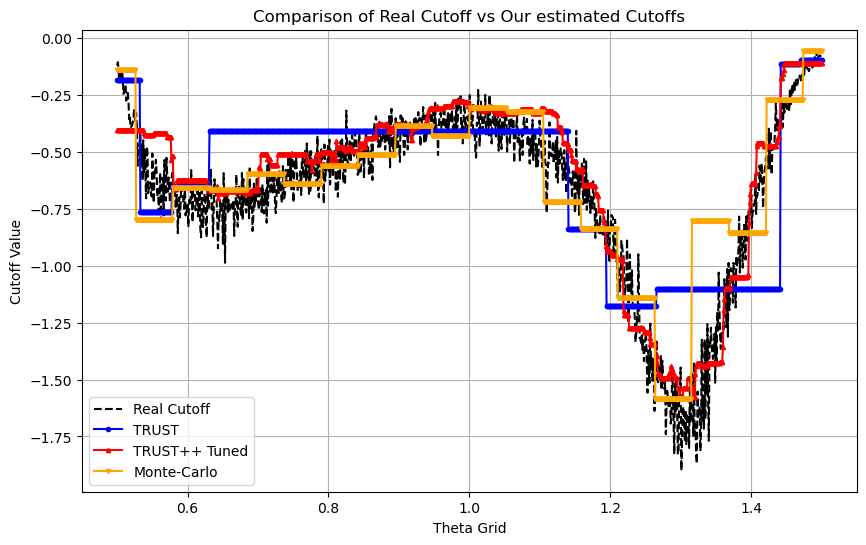

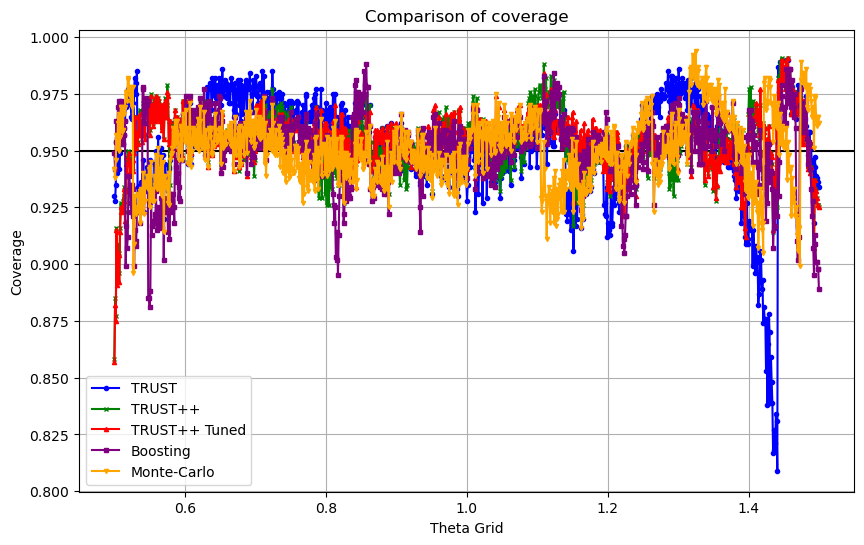

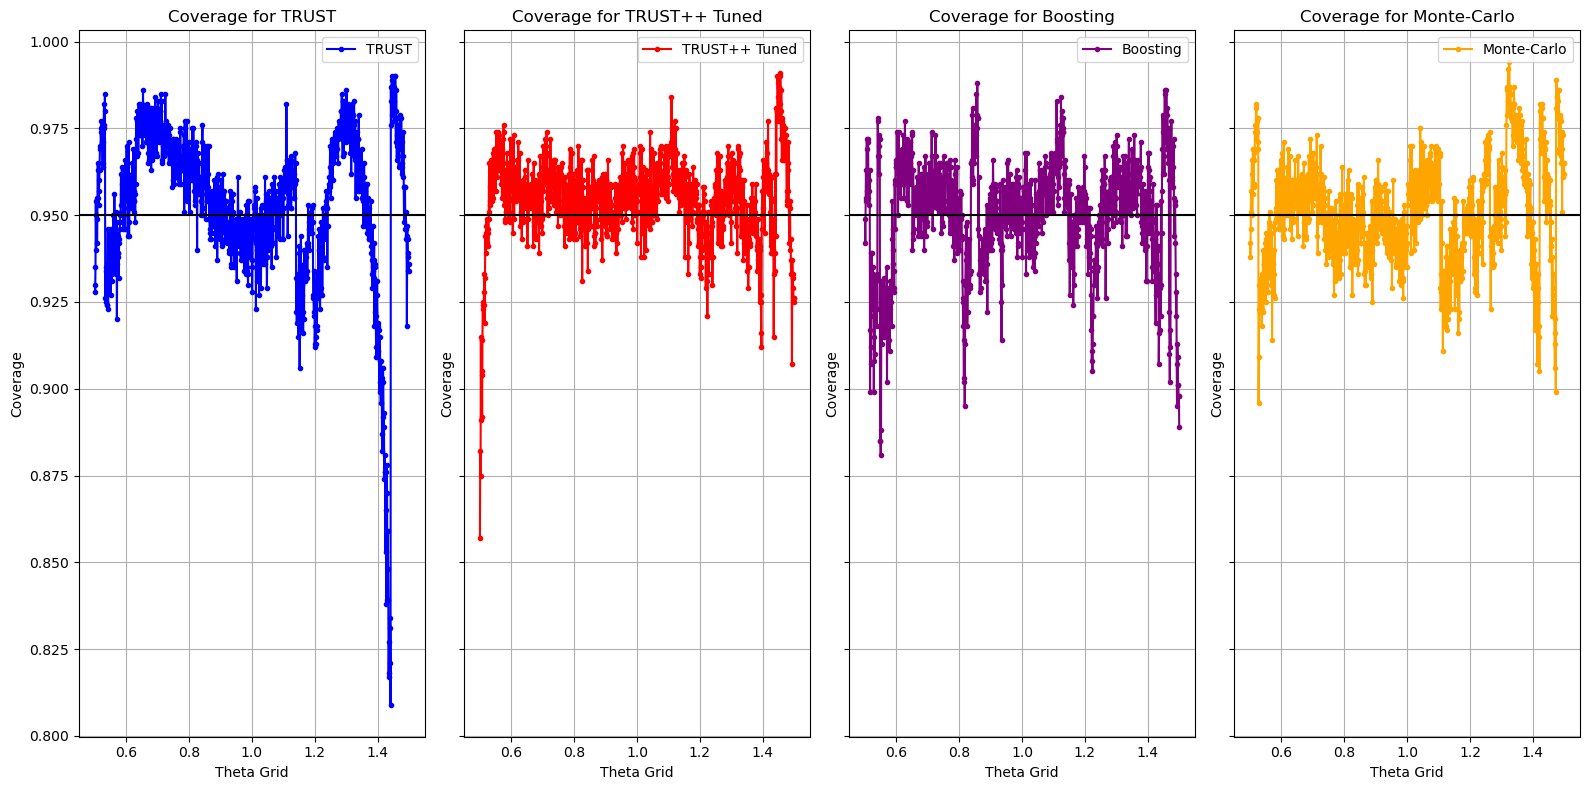

In [33]:
coverage_stats_bff_100 = compare_to_real(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 100, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 250,
    )

In [34]:
np.mean(np.abs(coverage_stats_bff_100[3] - (1 - 0.05)), axis = 0)

TRUST            0.016543
TRUST++          0.010574
TRUST++ tuned    0.009885
Boosting         0.012115
Monte Carlo      0.011702
dtype: float64